General analysis of loans under $150k that includes racial, gender and military status. Approximately 350k rows.

 

In [8]:
#import dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from datetime import date, datetime
import os, sys 
import io
import ee


In [9]:
## set up pandas dataframe using set_options to warn when we are working on a copy instead of ooriginal dataframe
pd.set_option('mode.chained_assignment','warn')

In [10]:
# dataframe will display without being truncated
pd.set_option('display.max_rows', 150)
pd.set_option('display.max_columns', 25)
pd.set_option('display.width', 768)

In [11]:
#mounting the google drive to access the files
from google.colab import files
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [12]:
#import csv that was cleaned up in cat_desc_normalize.ipynb
csv_path = "/content/drive/My Drive/p_cat_clean.csv"


In [13]:
#list of columns
cols=list(pd.read_csv(csv_path, nrows=1))
cols


['Loan Amount',
 'City',
 'State',
 'Zip',
 'NAICS Code',
 'Business Type',
 'Race',
 'Gender',
 'Veteran',
 'Jobs Saved',
 'Date',
 'Bank',
 'NAICS Category',
 'description',
 'Title']

In [14]:
# backup of clean dataframe, types will not be fully preserved so on import reassign, but easier with unconformity removed
df = pd.read_csv(csv_path, dtype={'Jobs Saved':int, 'NAICS Code': str, 'NAICS Category': str, 'Zip': str, }, parse_dates=[10] )
df.sample()

,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title
64818,46700.0,CRANSTON,RI,2920,722514,Corporation,White,Male Owned,Non-Veteran,6,2020-06-15,The Washington Trust Company of Westerly,72,Accommodation and Food Services,"Cafeterias, Grill Buffets, and Buffets"


In [15]:
#found some weird characters
df['Bank']=df['Bank'].str.lstrip('\t')

In [16]:
#types are correct
df.dtypes

Loan Amount              float64
City                      object
State                     object
Zip                       object
NAICS Code                object
Business Type             object
Race                      object
Gender                    object
Veteran                   object
Jobs Saved                 int64
Date              datetime64[ns]
Bank                      object
NAICS Category            object
description               object
Title                     object
dtype: object

In [17]:
#check shape
df.shape

(243964, 15)

General nationwide loan analysis


In [127]:
#check general statistics

nat_loan_stats=df['Loan Amount'].describe()
nat_loan_stats

count    243964.000000
mean      43003.115492
std       37055.317891
min           6.000000
25%       13941.000000
50%       30000.000000
75%       63877.125000
max      149987.000000
Name: Loan Amount, dtype: float64

In [128]:
#average loan amount
national_loan_avg=df['Loan Amount'].mean()
national_loan_avg

43003.115492286284

In [129]:
#median national loan
national_loan_med=df['Loan Amount'].median()
national_loan_med

30000.0

In [130]:
#sum of all loans
national_loan_sum=df['Loan Amount'].sum()
national_loan_sum

10491212067.959997

In [131]:
#number of jobs saved
nat_jobs_saved=df['Jobs Saved'].sum()
nat_jobs_saved

1505064

In [132]:
#sum of loans
national_loan_sum=df['Loan Amount'].sum()
national_loan_sum

10491212067.959997

In [133]:
#difference between national average and median 
nat_pct_dif=national_loan_avg/national_loan_med * 100
nat_pct_dif

143.34371830762095

In [134]:
# loan per job
nat_ln_per_job = national_loan_sum / nat_jobs_saved
print(nat_ln_per_job)

6970.608603992918


In [138]:
#summary table of stats
nat_summary = pd.DataFrame({
    'Loan Avg': national_loan_avg,
    'Loan Median': national_loan_med,
    'Loan Sum': national_loan_sum,
    'Loan Count': national_loan_count,
    'Jobs Saved': national_loan_sum,
    'Avg over Median': nat_pct_dif,
    'Money per Job' : nat_ln_per_job,
},index=[0])
nat_summary.head(3)

,Loan Avg,Loan Median,Loan Sum,Loan Count,Jobs Saved,Avg over Median,Money per Job
0,43003.115492,30000.0,1.049121e+10,243964,1.049121e+10,143.343718,6970.608604


# Summary Table

Loan Avg : $43,003.12 | Median Loan : $30,000 | Loan Sum: $10,491,212,067| Loan Count: 243,964 | Jobs Saved: 1,505,064 | Avg loan amount over Median: 143.34% | Money per Job: $6,970



In [139]:
nat_summary['Loan Avg'] = nat_summary.loc[:,'Loan Avg'].map("${:,.2f}".format)
nat_summary['Loan Median'] = nat_summary.loc[:,'Loan Median'].map("${:,.2f}".format)
nat_summary['Loan Sum'] = nat_summary.loc[:,'Loan Sum'].map("{:,}".format)
nat_summary['Loan Count'] = nat_summary.loc[:,'Loan Count'].map("{:,}".format)
nat_summary['Jobs Saved'] = nat_summary.loc[:,'Jobs Saved'].map("{:,}".format)
nat_summary['Avg over Median'] = nat_summary.loc[:,'Avg over Median'].map("{:,.2f}%".format)
nat_summary['Money per Job'] = nat_summary.loc[:,'Money per Job'].map("${:,.2f}".format)
nat_summary






,Loan Avg,Loan Median,Loan Sum,Loan Count,Jobs Saved,Avg over Median,Money per Job
0,"$43,003.12","$30,000.00","10,491,212,067.959997","243,964","10,491,212,067.959997",143.34%,"$6,970.61"


Lender overview


In [27]:
#who are the top lenders by total sum of loans issued? Creating a summary table that can be exported to csv for analysis in SQL/ Tableau later
top_bank_sums=df.groupby('Bank').sum()['Loan Amount']
top_bank_sums

Bank
121 Financial CU       1912450.00
1880 Bank               107221.00
1st Advantage Bank     2203387.84
1st Bank                 58721.50
1st Bank Yuma          1269200.00
                          ...    
bankcda                 925300.00
cPort CU                303640.85
iTHINK Financial CU    2682900.00
immito                 3025085.00
mBank                  7370360.00
Name: Loan Amount, Length: 4087, dtype: float64

In [28]:
#top banks by median loan amount

top_bank_median=df.groupby('Bank').median()['Loan Amount']
top_bank_median

Bank
121 Financial CU       56750.00
1880 Bank              20833.00
1st Advantage Bank     36472.50
1st Bank                7867.00
1st Bank Yuma          40400.00
                         ...   
bankcda                24600.00
cPort CU               26404.35
iTHINK Financial CU    42600.00
immito                 19500.00
mBank                  43300.00
Name: Loan Amount, Length: 4087, dtype: float64

In [29]:
#banks highest average loan
top_bank_average=df.groupby('Bank').mean()['Loan Amount']
top_bank_average

Bank
121 Financial CU       53123.611111
1880 Bank              21444.200000
1st Advantage Bank     52461.615238
1st Bank                8388.785714
1st Bank Yuma          60438.095238
                           ...     
bankcda                46265.000000
cPort CU               43377.264286
iTHINK Financial CU    54753.061224
immito                 31843.000000
mBank                  53024.172662
Name: Loan Amount, Length: 4087, dtype: float64

In [30]:
#bank summary table
banks_summary_df=pd.DataFrame({
    'Loan Sum' : top_bank_sums,
    'Average Loan' : top_bank_average,
    'Median Loan' : top_bank_median
  
})
banks_summary_df.head()


,Loan Sum,Average Loan,Median Loan
Bank,,,
121 Financial CU,1912450.00,53123.611111,56750.0
1880 Bank,107221.00,21444.200000,20833.0
1st Advantage Bank,2203387.84,52461.615238,36472.5
1st Bank,58721.50,8388.785714,7867.0
1st Bank Yuma,1269200.00,60438.095238,40400.0


In [31]:
#formatting
banks_summary_df['Loan Sum'] = banks_summary_df.loc[:,'Loan Sum'].map("${:,.2f}".format)
banks_summary_df['Average Loan'] = banks_summary_df.loc[:,'Average Loan'].map("${:,.2f}".format)
banks_summary_df['Median Loan'] = banks_summary_df.loc[:,'Median Loan'].map("${:,.2f}".format)
banks_summary_df.sample(30)


,Loan Sum,Average Loan,Median Loan
Bank,,,
Labette Bank,"$1,338,500.00","$39,367.65","$28,250.00"
Bankers' Bank of Kansas,"$558,948.10","$31,052.67","$21,844.51"
Grand Ridge National Bank,"$2,902,865.81","$55,824.34","$46,228.50"
The Croghan Colonial Bank,"$2,256,722.00","$48,015.36","$36,000.00"
Old Second National Bank,"$1,061,600.00","$55,873.68","$48,000.00"
Orrstown Bank,"$2,087,740.00","$40,148.85","$31,000.00"
PFCU,"$118,589.00","$23,717.80","$19,307.00"
Cambridge State Bank,"$1,278,126.00","$49,158.69","$35,853.00"
Bar Harbor Bank & Trust,"$5,024,534.00","$38,355.22","$25,100.00"


In [32]:
#csv of bank summary
banks_summary_df.to_csv('banks_summary_df.csv', index=True)
!cp banks_summary_df.csv "drive/My Drive/"

In [33]:
result=8142/243964
result

0.033373776458821794

In [34]:
#some of the top institutions by state that considering they are regional have a relatively large percentage of the loans
# for example OH - Huntington bank did 3.3% of the loan count for this dataset Mississippi
top_bks_state=df.groupby('State')['Bank'].value_counts().nlargest(15)
top_bks_state

State  Bank                         
OH     The Huntington National Bank     8142
MI     The Huntington National Bank     3948
CA     City National Bank               2912
       East West Bank                   2074
MS     Community Bank of Mississippi    1967
OH     The Park National Bank           1914
CT     Liberty Bank                     1607
OK     RCB Bank                         1323
NY     Dime Community Bank               949
FL     Capital City Bank                 940
OH     Peoples Bank                      909
IN     The Huntington National Bank      876
TX     WestStar Bank                     867
IA     Northwest Bank                    780
TX     Frost Bank                        775
Name: Bank, dtype: int64

In [35]:
#send top bank summary to csv
top_bks_state.to_csv('bks_by_state.csv', index=True)
!cp top_bks_state.csv "drive/My Drive/"

cp: cannot stat 'top_bks_state.csv': No such file or directory


Business Category overview

In [36]:
#sum of loans by category
loans_cat=df.groupby('description')['Loan Amount'].sum()
loans_cat.head()

description
Accommodation and Food Services             1.777470e+09
Agriculture Forestry Fishing and Hunting    2.818954e+08
Arts Entertainment and Recreation           3.126078e+08
Construction                                1.137631e+09
Educational Services                        1.253895e+08
Name: Loan Amount, dtype: float64

In [37]:
#sum of jobs saved by category
jobs_cat=df.groupby('description')['Jobs Saved'].sum()
jobs_cat.head()

description
Accommodation and Food Services             401364
Agriculture Forestry Fishing and Hunting     41672
Arts Entertainment and Recreation            65998
Construction                                121912
Educational Services                         24849
Name: Jobs Saved, dtype: int64

In [38]:
#median loan by category
median_cat=df.groupby('description')['Loan Amount'].median()
median_cat.head()

description
Accommodation and Food Services             43892.000
Agriculture Forestry Fishing and Hunting    14245.500
Arts Entertainment and Recreation           23398.420
Construction                                33004.335
Educational Services                        23300.000
Name: Loan Amount, dtype: float64

In [39]:
#average loan by category 
mean_cat=df.groupby('description')['Loan Amount'].mean()
mean_cat.head()

description
Accommodation and Food Services             52648.609625
Agriculture Forestry Fishing and Hunting    22404.659389
Arts Entertainment and Recreation           36643.741519
Construction                                45765.193712
Educational Services                        38263.516494
Name: Loan Amount, dtype: float64

In [40]:
#summary category table
category_summary_df=pd.DataFrame({
    'Jobs Saved' : jobs_cat,
    'Median Loan' : median_cat,
    'Average Loan' : mean_cat,
    'Total Loans': loans_cat,
  
})
category_summary_df.head()

,Jobs Saved,Median Loan,Average Loan,Total Loans
description,,,,
Accommodation and Food Services,401364,43892.000,52648.609625,1.777470e+09
Agriculture Forestry Fishing and Hunting,41672,14245.500,22404.659389,2.818954e+08
Arts Entertainment and Recreation,65998,23398.420,36643.741519,3.126078e+08
Construction,121912,33004.335,45765.193712,1.137631e+09
Educational Services,24849,23300.000,38263.516494,1.253895e+08


No surprise - Hospitality industry seemed to take the biggest hit with Construction and Health Care loans the next highest number of jobs saved. Seemingly unexpected are Professional and Technical Services and Waste Management which may deserve a "look under the hood".

In [41]:
#formatting
category_summary_df['Jobs Saved'] = category_summary_df.loc[:,'Jobs Saved'].map("{:,}".format)
category_summary_df['Median Loan'] = category_summary_df.loc[:,'Median Loan'].map("${:,.2f}".format)
category_summary_df['Average Loan'] = category_summary_df.loc[:,'Average Loan'].map("${:,.2f}".format)
category_summary_df['Total Loans'] = category_summary_df.loc[:,'Total Loans'].map("${:,.2f}".format)
category_summary_df.head(30)

,Jobs Saved,Median Loan,Average Loan,Total Loans
description,,,,
Accommodation and Food Services,"401,364","$43,892.00","$52,648.61","$1,777,469,709.56"
Agriculture Forestry Fishing and Hunting,"41,672","$14,245.50","$22,404.66","$281,895,424.43"
Arts Entertainment and Recreation,"65,998","$23,398.42","$36,643.74","$312,607,758.90"
Construction,"121,912","$33,004.33","$45,765.19","$1,137,631,185.30"
Educational Services,"24,849","$23,300.00","$38,263.52","$125,389,543.55"
Finance and Insurance,"32,834","$25,000.00","$36,114.94","$326,515,161.20"
Health Care and Social Assistance,"181,129","$41,972.00","$51,198.71","$1,446,312,284.14"
Information,"15,827","$28,031.50","$41,966.92","$138,826,567.69"
Management of Companies and Enterprises,"2,611","$40,000.00","$51,347.33","$21,514,529.30"


In [42]:
#save to csv and will convert to a table in SQL / Tableau for further analysis 

category_summary_df.to_csv('category_summary.csv', index=True)
!cp category_summary.csv "drive/My Drive/"

Adding columns for day of the week and percentiles



In [44]:
# df['Loan PCL']=pd.qcut(df['Loan Amount'], q=10)

bin_labels_10= ['10%', '20%', '30%', '40%', '50%', '60%', '70%', '80%', '90%' ]
df['Loan Percentile'] = pd.qcut(df['Loan Amount'],
                              q=[0,  .10, .20, .30, .40, .50, .60, .70, .80, 1],
                              labels=bin_labels_10)
df.sample()

,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title,Loan Percentile
194453,5000.0,CANAL WINCHESTER,OH,43110,71394,Corporation,White,Male Owned,Non-Veteran,1,2020-04-15,The Park National Bank,71,Arts Entertainment and Recreation,Fitness and Recreational Sports CentersT,10%


In [45]:
#binning quartiles
bin_labels_4 = ['25%', '45%', '50%', '75%', ]
df['Loan Quartile'] = pd.qcut(df['Loan Amount'],
                              q=[0, .25, .50, .75, 1],
                              labels=bin_labels_4)
df.sample()

,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title,Loan Percentile,Loan Quartile
155373,52400.0,DUBLIN,OH,43017,44211,Limited Liability Company(LLC),White,Female Owned,Non-Veteran,7,2020-04-13,KeyBank National Association,44,Retail Trade,Furniture Stores,70%,50%


In [43]:
# loan sum by state
sum_by_state=df.groupby('State',)['Loan Amount'].sum() 
sum_by_state.nlargest(8)

State
CA    1.011667e+09
TX    8.442114e+08
OH    7.525145e+08
FL    5.129656e+08
NY    4.587963e+08
IL    4.051708e+08
MN    3.652874e+08
GA    3.530695e+08
Name: Loan Amount, dtype: float64

In [46]:
# day of the week
df['DayNUM']= pd.to_datetime(df['Date']).dt.dayofweek
df.sample()

,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title,Loan Percentile,Loan Quartile,DayNUM
7357,25500.0,MERRILL,IA,51038,23891,Corporation,White,Male Owned,Non-Veteran,2,2020-04-05,Northwest Bank,23,Construction,Site Preparation ContractorsT,50%,45%,6


In [47]:
# monday most common day for loan issuance
df['DayNUM'].value_counts()

1    62903
0    48712
2    47748
3    30221
4    28126
5    16887
6     9367
Name: DayNUM, dtype: int64

The 90th percentile of loans account for 20% of total in terms of loan amount


In [48]:
df['Loan Quartile'].value_counts()

45%    61335
25%    60992
75%    60991
50%    60646
Name: Loan Quartile, dtype: int64

In [49]:
# replace numerical representation with day name

day_labels= {'0': 'Mon', '1':'Tues', '2' : 'Wed', '3':'Thurs', '4': 'Fri', '5':'Sat', '6' :'Sun'}
df['Weekday'] = df['DayNUM'].astype(str).replace(day_labels)
df.sample()

,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title,Loan Percentile,Loan Quartile,DayNUM,Weekday
417,47201.0,JANESVILLE,WI,53548,23811,Limited Liability Company(LLC),White,Male Owned,Non-Veteran,0,2020-04-30,Associated Bank,23,Construction,Poured Concrete Foundation and Structure Contr...,70%,50%,3,Thurs


In [50]:
# shorten names of business types and combine some that are similar such as joint venture and partnership
df['Business Type'] = df['Business Type'].replace({'Limited  Liability Company(LLC)':'LLC', 
                                                   'Subchapter S Corporation': 'S Corp', 
                                                   'Self-Employed Individuals':'Self Employed', 
                                                   'Independent Contractors' : 'Self Employed',
                                                   'Non-Profit Organization': 'Non-Profit',
                                                   'Limited Liability Partnership': 'Partnership',
                                                   'Joint Venture':'Partnership'
                                                   })
df.sample()

,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title,Loan Percentile,Loan Quartile,DayNUM,Weekday
176531,39960.0,JACKSON,MS,39201,53119,Corporation,White,Male Owned,Non-Veteran,6,2020-04-05,Guaranty Bank & Trust Company,53,Real Estate Rental and Leasing,Lessors of Other Real Estate Property,60%,50%,6,Sun


In [51]:
# business types by count
df['Business Type'].value_counts()

LLC                                    82746
Corporation                            77805
S Corp                                 37588
Sole Proprietorship                    30405
Self Employed                           7871
Partnership                             4999
Non-Profit                              1356
Professional Association                 791
Cooperative                              253
Non-Profit Childcare Center               86
Trust                                     41
Employee Stock Ownership Plan(ESOP)       18
Tenant in Common                           4
Rollover as Business Start-Ups (ROB        1
Name: Business Type, dtype: int64

Gender, race and military status explored

In [52]:
df['Gender'].value_counts()

Male Owned      179453
Female Owned     64511
Name: Gender, dtype: int64

In [53]:
# gender value shortened 
df['Gender'] = df['Gender'].replace({'Male Owned':'Male', 'Female Owned': 'Female', })
df.sample()

,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title,Loan Percentile,Loan Quartile,DayNUM,Weekday
120876,5100.0,PHOENIX,AZ,85018,541611,Sole Proprietorship,White,Male,Non-Veteran,0,2020-05-12,Arizona FCU,54,Professional Scientific and Technical Services,Administrative Management and General Manageme...,10%,25%,1,Tues


In [54]:
#value counts of race
df['Race'].value_counts()

White                               184816
Asian                                30802
Hispanic                             19594
Black or African American             7373
American Indian or Alaska Native      1296
Puerto Rican                            76
Multi Group                              4
Eskimo & Aleut                           3
Name: Race, dtype: int64

In [55]:
#shorten race values
df['Race'] = df['Race'].replace({'Black or African American':'Black', 'American Indian or Alaska Native': 'Native American', 'Eskimo & Aleut':'Eskimo'})
df.sample()

,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title,Loan Percentile,Loan Quartile,DayNUM,Weekday
234228,8400.0,BILLINGS,MT,59101,453991,LLC,White,Male,Non-Veteran,2,2020-04-13,The Yellowstone Bank,45,Retail Trade,Tobacco Stores,20%,25%,0,Mon


In [56]:
#send dataframe for all values to csv (additional columns and null values cleaned)
df.to_csv('full_monty_peeps.csv', index=True)
!cp full_monty_peeps.csv "drive/My Drive/"

In [57]:
#loan quartiles
loan_qt = np.percentile(df['Loan Amount'], [25, 50, 75, 100])
loan_qt


array([ 13941.   ,  30000.   ,  63877.125, 149987.   ])

In [58]:
# top 10 percent of loans
high_pct = df[(df["Loan Percentile"] == '90%')]

high_pct.head(1)


,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title,Loan Percentile,Loan Quartile,DayNUM,Weekday
0,149810.9,ADRIAN,MO,64720,23811,LLC,White,Female,Non-Veteran,13,2020-04-13,Adrian Bank,23,Construction,Poured Concrete Foundation and Structure Contr...,90%,75%,0,Mon


In [59]:
#save to csv and will convert to a table in SQL / Tableau for further analysis 

high_pct.to_csv('top_percentile_banks.csv', index=True)
!cp top_percentile_banks.csv "drive/My Drive/"

Some lines of inquiry to pursue pertaining to race and gender
From the subset of people who self identified racially, Asians borrowed a disproporianatly larger amount as a percentage of population and Hispanics less. (Asians are less than 6% and Hispanics 16%). Puerto Ricans are not necessarily accounted for in the Hispanic statistics. It is hard to say whether or not this is a true representation of percentages of all loans because this dataset is small (less than 5% of the total) and only reflects the people who were willing to answer the race inquiry. Asians and Whites had roughly the same gender percentages, median and average loan amounts. Hispanics and Blacks seemed to incur lower levels of debt.

In [60]:
# race counts by state
state_race_cts=df.groupby('State',)['Race'].value_counts()
state_race_cts.head()

State  Race    
AE     Asian         1
AK     White       292
       Hispanic     25
       Asian        23
       Black        12
Name: Race, dtype: int64

In [140]:
df.sample()

,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title,Loan Percentile,Loan Quartile,DayNUM,Weekday
179971,54072.0,MORRISTOWN,TN,37813,532111,Corporation,White,Male,Non-Veteran,9,2020-04-08,Andrew Johnson Bank,53,Real Estate Rental and Leasing,Passenger Car Rental,70%,50%,2,Wed


In [62]:
#average loan amount by race
race_avg=df.groupby('Race')['Loan Amount'].mean()
race_avg

Race
Asian              42481.101465
Black              33785.591485
Eskimo              6166.666667
Hispanic           39374.129248
Multi Group        18202.250000
Native American    41913.462438
Puerto Rican       16440.836053
White              43862.277434
Name: Loan Amount, dtype: float64

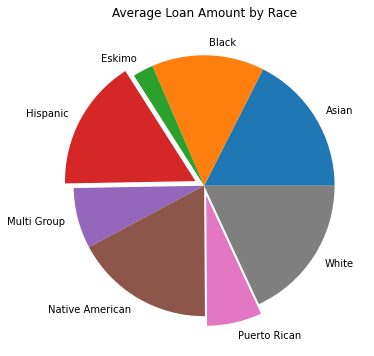

In [143]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title = "Average Loan Amount by Race",
       xlabel = "", 
       ylabel = "",

       )
labels=race_avg.index
explode = (0.0, 0.0, 0.0, 0.075, 0, 0,  0.075, 0)
# Define x and y axes
ax.pie(race_avg, explode=explode, labels=labels)
plt.savefig('avg_loan_race.png', bbox_inches="tight")

In [144]:
# df.groupby('Race', 'Loan Amount').quantile()
race_count=df.groupby('Race').count()
print(race_count)

                 Loan Amount    City   State     Zip  NAICS Code  Business Type  Gender  Veteran  Jobs Saved    Date    Bank  NAICS Category  description   Title  Loan Percentile  Loan Quartile  DayNUM  Weekday
Race                                                                                                                                                                                                              
Asian                  30802   30802   30802   30802       30802          30802   30802    30802       30802   30802   30802           30802        30802   30802            30802          30802   30802    30802
Black                   7373    7373    7373    7373        7373           7373    7373     7373        7373    7373    7373            7373         7373    7373             7373           7373    7373     7373
Eskimo                     3       3       3       3           3              3       3        3           3       3       3               3            3   

Difference between veteran and non veteran lending by race. Significant difference for hispanic and blacks, veterans getting higher loan amounts. Puerto Ricans are the outlier here Non-Veteran loans being higher than those who did military service. 

In [66]:
#veterans loan quantile by race
vt_gen_qt=df.groupby(['Race', 'Veteran'])['Loan Amount'].quantile()
vt_gen_qt

Race             Veteran    
Asian            Non-Veteran    31000.000
                 Veteran        32000.000
Black            Non-Veteran    20832.000
                 Veteran        23600.000
Eskimo           Non-Veteran     5300.000
Hispanic         Non-Veteran    25000.000
                 Veteran        30550.000
Multi Group      Non-Veteran    18966.500
Native American  Non-Veteran    28482.500
                 Veteran        31503.735
Puerto Rican     Non-Veteran    11400.000
                 Veteran         8200.000
White            Non-Veteran    30600.000
                 Veteran        34200.000
Name: Loan Amount, dtype: float64

In [149]:
#puerto rican veteran vs non 139 percent
pr = 11400.000/8200 * 100
pr

139.02439024390242

In [151]:
#business categories by race and military status
vt_cat=df.groupby(['Race', 'Veteran'])['description'].value_counts()
vt_cat

Race   Veteran      description                                   
Asian  Non-Veteran  Accommodation and Food Services                   10978
                    Retail Trade                                       7621
                    Health Care and Social Assistance                  2980
                    Wholesale Trade                                    1964
                    Professional Scientific and Technical Services     1610
                                                                      ...  
White  Veteran      Educational Services                                129
                    Information                                         107
                    Mining                                               47
                    Management of Companies and Enterprises              20
                    Utilities                                            18
Name: description, Length: 218, dtype: int64

In [68]:
df.sample()

,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title,Loan Percentile,Loan Quartile,DayNUM,Weekday
87375,8751.45,SCOTTSDALE,AZ,85258,62134,LLC,White,Female,Non-Veteran,1,2020-04-27,FineMark National Bank & Trust,62,Health Care and Social Assistance,"Offices of Physical, Occupational and Speech T...",20%,25%,0,Mon


In [69]:
#jobs saved by jobs and gender
rc_jbs=df.groupby(['Race', 'Gender'])['Jobs Saved'].sum()
rc_jbs

Race             Gender
Asian            Female     53218
                 Male      172992
Black            Female     15755
                 Male       24329
Eskimo           Female         0
                 Male           2
Hispanic         Female     37573
                 Male       79656
Multi Group      Female         5
                 Male          14
Native American  Female      2772
                 Male        5606
Puerto Rican     Female        36
                 Male         191
White            Female    280288
                 Male      832627
Name: Jobs Saved, dtype: int64

In [70]:
#median loan amounts by race and gender
race_median=df.groupby(['Race', 'Gender'])['Loan Amount'].median()
race_median

Race             Gender
Asian            Female    29141.700
                 Male      31800.000
Black            Female    20023.750
                 Male      20833.000
Eskimo           Female     8300.000
                 Male       5100.000
Hispanic         Female    20800.000
                 Male      29174.475
Multi Group      Female    10376.000
                 Male      20833.000
Native American  Female    25913.750
                 Male      30671.000
Puerto Rican     Female     9899.000
                 Male      11499.000
White            Female    25700.000
                 Male      32500.000
Name: Loan Amount, dtype: float64

In [71]:
# average loan amounts by race and gender
race_mean=df.groupby(['Race', 'Gender'])['Loan Amount'].mean()
race_mean

Race             Gender
Asian            Female    40539.532365
                 Male      43146.743605
Black            Female    31415.972187
                 Male      35270.197443
Eskimo           Female     8300.000000
                 Male       5100.000000
Hispanic         Female    33608.471865
                 Male      42781.278845
Multi Group      Female    10376.000000
                 Male      20811.000000
Native American  Female    38452.010607
                 Male      43526.718269
Puerto Rican     Female    14499.000000
                 Male      16879.315161
White            Female    39517.691786
                 Male      45306.171339
Name: Loan Amount, dtype: float64

In [72]:
# shape
df.shape

(243964, 19)

In [73]:
#race gender quantiles
rc_gen_qt=df.groupby(['Race', 'Gender'])['Loan Amount'].quantile()


In [74]:
#counts by race gender
counts_by_race=df.groupby(['Race', 'Gender'])['Loan Amount'].count()
counts_by_race

Race             Gender
Asian            Female      7864
                 Male       22938
Black            Female      2840
                 Male        4533
Eskimo           Female         1
                 Male           2
Hispanic         Female      7278
                 Male       12316
Multi Group      Female         1
                 Male           3
Native American  Female       412
                 Male         884
Puerto Rican     Female        14
                 Male          62
White            Female     46101
                 Male      138715
Name: Loan Amount, dtype: int64

In [75]:
#race summary table

race_summary= pd.DataFrame({
    'Count' : counts_by_race,
    'Quantile' : rc_gen_qt,
    'Mean' : race_mean,
    'Median' : race_median,
    'Jobs' : rc_jbs


})
race_summary.head()

Count  Quantile          Mean    Median    Jobs
Race   Gender                                                 
Asian  Female   7864  29141.70  40539.532365  29141.70   53218
       Male    22938  31800.00  43146.743605  31800.00  172992
Black  Female   2840  20023.75  31415.972187  20023.75   15755
       Male     4533  20833.00  35270.197443  20833.00   24329
Eskimo Female      1   8300.00   8300.000000   8300.00       0

In [76]:
#formatting
race_summary['Count'] = race_summary.loc[:,'Count'].map("{:,}".format)
race_summary['Jobs'] = race_summary.loc[:,'Jobs'].map("{:,}".format)
race_summary['Quantile'] = race_summary.loc[:,'Quantile'].map("${:,.2f}".format)
race_summary['Mean'] = race_summary.loc[:,'Mean'].map("${:,.2f}".format)
race_summary['Median'] = race_summary.loc[:,'Median'].map("${:,.2f}".format)
race_summary

Count    Quantile        Mean      Median     Jobs
Race            Gender                                                      
Asian           Female    7,864  $29,141.70  $40,539.53  $29,141.70   53,218
                Male     22,938  $31,800.00  $43,146.74  $31,800.00  172,992
Black           Female    2,840  $20,023.75  $31,415.97  $20,023.75   15,755
                Male      4,533  $20,833.00  $35,270.20  $20,833.00   24,329
Eskimo          Female        1   $8,300.00   $8,300.00   $8,300.00        0
                Male          2   $5,100.00   $5,100.00   $5,100.00        2
Hispanic        Female    7,278  $20,800.00  $33,608.47  $20,800.00   37,573
                Male     12,316  $29,174.47  $42,781.28  $29,174.47   79,656
Multi Group     Female        1  $10,376.00  $10,376.00  $10,376.00        5
                Male          3  $20,833.00  $20,811.00  $20,833.00       14
Native American Female      412  $25,913.75  $38,452.01  $25,913.75    2,772
                Male        884  $30,671.00  $43,526.72  $30,671.00    5,606
Puerto Rican    Female       14   $9,899.00  $14,499.00   $9,899.00       36
                Male         62  $11,499.00  $16,879.32  $11,499.00      191
White           Female   46,101  $25,700.00  $39,517.69  $25,700.00  280,288
                Male    138,715  $32,500.00  $45,306.17  $32,500.00  832,627

In [77]:
#save to csv and will convert to a table in SQL / Tableau for further analysis 

race_summary.to_csv('race_summary.csv', index=True)
!cp race_summary.csv "drive/My Drive/"

In [78]:
df.sample()


,Loan Amount,City,State,Zip,NAICS Code,Business Type,Race,Gender,Veteran,Jobs Saved,Date,Bank,NAICS Category,description,Title,Loan Percentile,Loan Quartile,DayNUM,Weekday
128335,12000.0,MINNEAPOLIS,MN,55401,54132,Corporation,Hispanic,Male,Non-Veteran,1,2020-05-01,Sunrise Banks,54,Professional Scientific and Technical Services,Landscape Architectural ServicesT,30%,25%,4,Fri


In [79]:
# sum of jobs saved by category
cat_sum=df.groupby('description')['Jobs Saved'].sum()
cat_sum.head()

description
Accommodation and Food Services             401364
Agriculture Forestry Fishing and Hunting     41672
Arts Entertainment and Recreation            65998
Construction                                121912
Educational Services                         24849
Name: Jobs Saved, dtype: int64

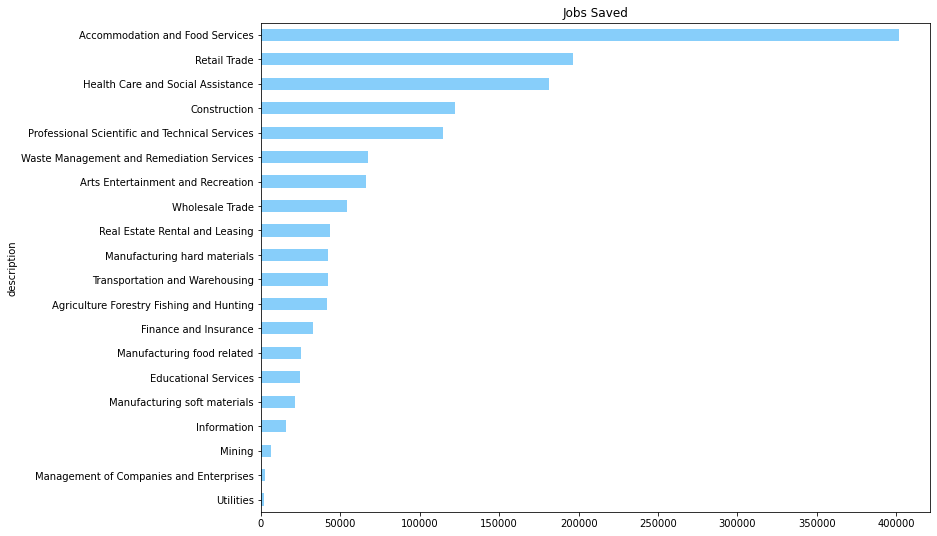

In [80]:
# jobs saved by category
cat_sum.sort_values().plot(kind='barh', y='Jobs Saved', subplots=True, figsize=(12,9), color="lightskyblue")
plt.savefig('category_jobs_saved.png', bbox_inches="tight")

In [81]:
# loan sum per category
cat_loan=df.groupby('description')['Loan Amount'].sum()
cat_loan.head()

description
Accommodation and Food Services             1.777470e+09
Agriculture Forestry Fishing and Hunting    2.818954e+08
Arts Entertainment and Recreation           3.126078e+08
Construction                                1.137631e+09
Educational Services                        1.253895e+08
Name: Loan Amount, dtype: float64

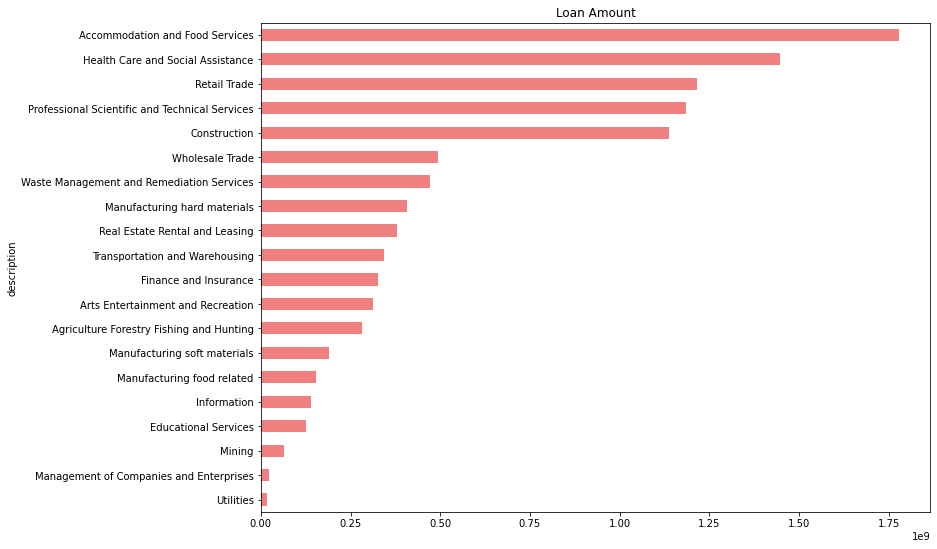

In [82]:
#changed color
cat_loan.sort_values().plot(kind='barh', y='Jobs Saved', subplots=True, figsize=(12,9), color="lightcoral")

plt.savefig('catgory_loans.png', bbox_inches="tight")

In [83]:
# count race by business type
count_race = df.groupby('Race').agg('count')
count_desc = df.groupby('description').agg('count')
count_sum = len(df)




In [84]:
# def group_lower_ranking_values(column):
#     pie_counts = df.groupby(column).agg('count')
#     pct_value = df[lambda df: df.columns[0]].quantile(.75)
#     values_below_pct_value = df[lambda df: df.columns[0]].loc[lambda s: s < pct_value].index.values
#     def fix_values(row):
#         if row[column] in values_below_pct_value:
#             row[column] = 'Other'
#         return row 
#     pie_grouped = df.apply(fix_values, axis=1).groupby(column).agg('count')
#     return pie_grouped

# racial_index = group_lower_ranking_values('Race')
# description_index = group_lower_ranking_values('description')

In [85]:
racial_index=df.groupby('Race').agg('count')
print(racial_index)

                 Loan Amount    City   State     Zip  NAICS Code  Business Type  Gender  Veteran  Jobs Saved    Date    Bank  NAICS Category  description   Title  Loan Percentile  Loan Quartile  DayNUM  Weekday
Race                                                                                                                                                                                                              
Asian                  30802   30802   30802   30802       30802          30802   30802    30802       30802   30802   30802           30802        30802   30802            30802          30802   30802    30802
Black                   7373    7373    7373    7373        7373           7373    7373     7373        7373    7373    7373            7373         7373    7373             7373           7373    7373     7373
Eskimo                     3       3       3       3           3              3       3        3           3       3       3               3            3   

In [86]:
gender_loan_amount=df.groupby('Gender')['Loan Amount'].agg('sum')
print(gender_loan_amount)

Gender
Female    2.490496e+09
Male      8.000716e+09
Name: Loan Amount, dtype: float64


In [87]:
%matplotlib inline

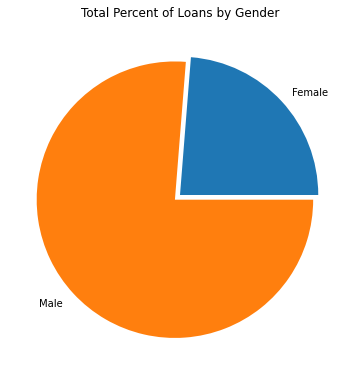

In [88]:
# Define plot space
fig, ax = plt.subplots(figsize=(10, 6))
ax.set(title = "Total Percent of Loans by Gender",
       xlabel = "", 
       ylabel = "",

       )
labels=gender_loan_amount.index
explode = (0.0, 0.05)
left  = 0.125  # the left side of the subplots of the figure
right = 0.9    # the right side of the subplots of the figure
bottom = 0.1   # the bottom of the subplots of the figure
top = 0.9      # the top of the subplots of the figure
wspace = 0.5  # the amount of width reserved for blank space between subplots
hspace = 0.5   # the amount of height reserved for white space between subplots
# These two can be called on 'fig' instead of 'plt' too
plt.subplots_adjust(left=left, bottom=bottom, right=right, top=top,
                wspace=wspace, hspace=hspace)

# Define x and y axes
ax.pie(gender_loan_amount, explode=explode, labels=labels, rotatelabels=False)
plt.savefig('gender_loan_total.png', bbox_inches='tight')

In [89]:
df.to_csv('ppl_ppp_w_quantiles_and_categories.csv', index=True)
!cp people_ppp_super.csv "drive/My Drive/"


cp: cannot stat 'people_ppp_super.csv': No such file or directory
